In [1]:
from pyexpat.errors import messages


# ENGINE = "text-davinci-002"
ENGINE = "gpt-4o-mini"

In [2]:
import os
print(os.environ.get("OPENAI_API"))

None


In [3]:
import collections
import datetime
import os
import random
import threading
import time
import cv2  # Used by ViLD.
import clip
from easydict import EasyDict
import flax
from flax import linen as nn
from flax.training import checkpoints
from flax.metrics import tensorboard
import imageio
from heapq import nlargest
import IPython
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from moviepy.editor import ImageSequenceClip
import numpy as np
import openai
import optax
import pickle
from PIL import Image
import pybullet
import pybullet_data
import tensorflow.compat.v1 as tf
import torch
from tqdm import tqdm

2024-08-29 10:52:55.799181: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 10:52:55.840773: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 10:52:55.853706: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 10:52:56.488238: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
pybullet build time: Nov 28 2023 23:45:17


In [6]:
from openai import OpenAI
client = OpenAI(api_key=openai_api_key)

response = client.chat.completions.create(
    model= "gpt-4o-mini",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Who won the indian premier league in 2016?"},
        # {"role": "assistant", "content": "The Los Angeles Dodgers won the World Series in 2020."},
        {"role": "user", "content": "Where was the final played?"}
    ]
)

In [7]:
response

ChatCompletion(id='chatcmpl-A1C4IfnrutmgweHt114XWf2bZxD6z', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The final of the Indian Premier League (IPL) in 2016 was played at the M. Chinnaswamy Stadium in Bengaluru, India. In that final, the Sunrisers Hyderabad (SRH) emerged victorious, defeating the Royal Challengers Bangalore (RCB) to win their first IPL title.', refusal=None, role='assistant', function_call=None, tool_calls=None))], created=1724848082, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier=None, system_fingerprint='fp_f33667828e', usage=CompletionUsage(completion_tokens=64, prompt_tokens=38, total_tokens=102))

In [8]:
# ViLD pretrained model weights.
# !gsutil cp -r gs://cloud-tpu-checkpoints/detection/projects/vild/colab/image_path_v2 ../resources/

In [9]:
%load_ext tensorboard

In [10]:
openai.api_key = openai_api_key

In [11]:
# Show useful GPU info.
!nvidia-smi

Wed Aug 28 14:29:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070        Off | 00000000:01:00.0  On |                  N/A |
|  0%   44C    P8              19W / 200W |    877MiB / 12282MiB |     10%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [12]:
# Show if JAX is using GPU.
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [13]:
from enviroment_setup import *

if 'env' in locals():
  # Safely exit gripper threading before re-initializing environment.
  env.gripper.running = False
  while env.gripper.constraints_thread.isAlive():
    time.sleep(0.01)
      
env = PickPlaceEnv()

In [14]:
# Define and reset environment.
config = {'pick':  ['yellow block', 'green block', 'blue block'],
          'place': ['yellow bowl', 'green bowl', 'blue bowl']}

np.random.seed(42)
obs = env.reset(config)

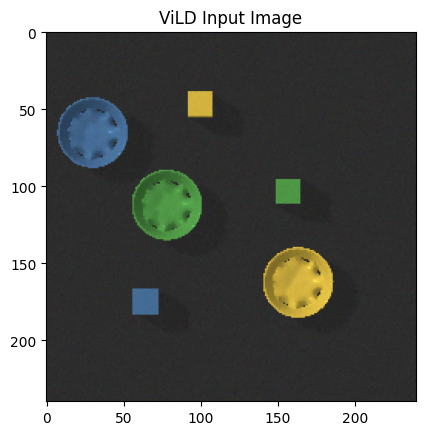

In [15]:
img = env.get_camera_image_top()
img = np.flipud(img.transpose(1, 0, 2))
plt.title('ViLD Input Image')
plt.imshow(img)
plt.show()
imageio.imwrite('../outputs/tmp2.jpg', img)

In [16]:
#@markdown Load CLIP model.

# torch.cuda.set_per_process_memory_fraction(0.9, None)
clip_model, clip_preprocess = clip.load("ViT-B/32")
clip_model.cuda().eval()
print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Input resolution:", clip_model.visual.input_resolution)
print("Context length:", clip_model.context_length)
print("Vocab size:", clip_model.vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [17]:
#@markdown Define ViLD hyperparameters.
FLAGS = {
    'prompt_engineering': True,
    'this_is': True,
    'temperature': 100.0,
    'use_softmax': False,
}
FLAGS = EasyDict(FLAGS)
# Parameters for drawing figure.
display_input_size = (10, 10)
overall_fig_size = (18, 24)

line_thickness = 1
fig_size_w = 35
# fig_size_h = min(max(5, int(len(category_names) / 2.5) ), 10)
mask_color =   'red'
alpha = 0.5

In [18]:

#@markdown ViLD prompt engineering.

def article(name):
  return "an" if name[0] in "aeiou" else "a"

def processed_name(name, rm_dot=False):
  # _ for lvis
  # / for obj365
  res = name.replace("_", " ").replace("/", " or ").lower()
  if rm_dot:
    res = res.rstrip(".")
  return res

single_template = [
    "a photo of {article} {}."
]

# multiple_templates = [
#     "There is {article} {} in the scene.",
#     "a painting of a {}.",
# ]

multiple_templates = [
    'There is {article} {} in the scene.',
    'There is the {} in the scene.',
    'a photo of {article} {} in the scene.',
    'a photo of the {} in the scene.',
    'a photo of one {} in the scene.',


    'itap of {article} {}.',
    'itap of my {}.',  # itap: I took a picture of
    'itap of the {}.',
    'a photo of {article} {}.',
    'a photo of my {}.',
    'a photo of the {}.',
    'a photo of one {}.',
    'a photo of many {}.',

    'a good photo of {article} {}.',
    'a good photo of the {}.',
    'a bad photo of {article} {}.',
    'a bad photo of the {}.',
    'a photo of a nice {}.',
    'a photo of the nice {}.',
    'a photo of a cool {}.',
    'a photo of the cool {}.',
    'a photo of a weird {}.',
    'a photo of the weird {}.',

    'a photo of a small {}.',
    'a photo of the small {}.',
    'a photo of a large {}.',
    'a photo of the large {}.',

    'a photo of a clean {}.',
    'a photo of the clean {}.',
    'a photo of a dirty {}.',
    'a photo of the dirty {}.',

    'a bright photo of {article} {}.',
    'a bright photo of the {}.',
    'a dark photo of {article} {}.',
    'a dark photo of the {}.',

    'a photo of a hard to see {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of {article} {}.',
    'a low resolution photo of the {}.',
    'a cropped photo of {article} {}.',
    'a cropped photo of the {}.',
    'a close-up photo of {article} {}.',
    'a close-up photo of the {}.',
    'a jpeg corrupted photo of {article} {}.',
    'a jpeg corrupted photo of the {}.',
    'a blurry photo of {article} {}.',
    'a blurry photo of the {}.',
    'a pixelated photo of {article} {}.',
    'a pixelated photo of the {}.',

    'a black and white photo of the {}.',
    'a black and white photo of {article} {}.',

    'a plastic {}.',
    'the plastic {}.',

    'a toy {}.',
    'the toy {}.',
    'a plushie {}.',
    'the plushie {}.',
    'a cartoon {}.',
    'the cartoon {}.',

    'an embroidered {}.',
    'the embroidered {}.',

    'a painting of the {}.',
    'a painting of a {}.',
]

def build_text_embedding(categories):
  if FLAGS.prompt_engineering:
    templates = multiple_templates
  else:
    templates = single_template

  run_on_gpu = torch.cuda.is_available()

  with torch.no_grad():
    all_text_embeddings = []
    print("Building text embeddings...")
    for category in tqdm(categories):
      texts = [
        template.format(processed_name(category["name"], rm_dot=True),
                        article=article(category["name"]))
        for template in templates]
      if FLAGS.this_is:
        texts = [
                 "This is " + text if text.startswith("a") or text.startswith("the") else text
                 for text in texts
                 ]
      texts = clip.tokenize(texts) #tokenize
      if run_on_gpu:
        texts = texts.cuda()
      text_embeddings = clip_model.encode_text(texts) #embed with text encoder
      text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)
      text_embedding = text_embeddings.mean(dim=0)
      text_embedding /= text_embedding.norm()
      all_text_embeddings.append(text_embedding)
    all_text_embeddings = torch.stack(all_text_embeddings, dim=1)
    if run_on_gpu:
      all_text_embeddings = all_text_embeddings.cuda()
  return all_text_embeddings.cpu().numpy().T

In [19]:
#@markdown Load ViLD model.
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
session = tf.Session(graph=tf.Graph(), config=tf.ConfigProto(gpu_options=gpu_options))

I0000 00:00:1724848178.831206   34822 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-28 14:29:38.833683: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [20]:
saved_model_dir = "../resources/image_path_v2"
_ = tf.saved_model.load(session, ["serve"], saved_model_dir)

numbered_categories = [{"name": str(idx), "id": idx,} for idx in range(50)]
numbered_category_indices = {cat["id"]: cat for cat in numbered_categories}

Instructions for updating:
Use `tf.saved_model.load` instead.


In [21]:
#@markdown Non-maximum suppression (NMS).
def nms(dets, scores, thresh, max_dets=1000):
  """Non-maximum suppression.
  Args:
    dets: [N, 4]
    scores: [N,]
    thresh: iou threshold. Float
    max_dets: int.
  """
  y1 = dets[:, 0]
  x1 = dets[:, 1]
  y2 = dets[:, 2]
  x2 = dets[:, 3]

  areas = (x2 - x1) * (y2 - y1)
  order = scores.argsort()[::-1]

  keep = []
  while order.size > 0 and len(keep) < max_dets:
    i = order[0]
    keep.append(i)

    xx1 = np.maximum(x1[i], x1[order[1:]])
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])

    w = np.maximum(0.0, xx2 - xx1)
    h = np.maximum(0.0, yy2 - yy1)
    intersection = w * h
    overlap = intersection / (areas[i] + areas[order[1:]] - intersection + 1e-12)

    inds = np.where(overlap <= thresh)[0]
    order = order[inds + 1]
  return keep

In [22]:
#@markdown ViLD Result Visualization
import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

STANDARD_COLORS = ["White"]

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color="red",
                               thickness=4,
                               display_str_list=(),
                               use_normalized_coordinates=True):
    
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
  else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
  try:
    font = ImageFont.truetype("arial.ttf", 24)
  except IOError:
    font = ImageFont.load_default()

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [draw.textbbox((0, 0), ds, font=font)[3] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_left = min(5, left)
    # text_width, text_height = font.getsize(display_str)
    bbox = draw.textbbox((0, 0), display_str, font=font)
    text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle(
        [(left, text_bottom - text_height - 2 * margin), (left + text_width,
                                                          text_bottom)],
        fill=color)
    draw.text(
        (left + margin, text_bottom - text_height - margin),
        display_str,
        fill="black",
        font=font)
    text_bottom -= text_height - 2 * margin

def draw_bounding_box_on_image_array(image,
                                     ymin,
                                     xmin,
                                     ymax,
                                     xmax,
                                     color="red",
                                     thickness=4,
                                     display_str_list=(),
                                     use_normalized_coordinates=True):
  """Adds a bounding box to an image (numpy array).

  Bounding box coordinates can be specified in either absolute (pixel) or
  normalized coordinates by setting the use_normalized_coordinates argument.

  Args:
    image: a numpy array with shape [height, width, 3].
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: list of strings to display in box
                      (each to be shown on its own line).
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
  """
  image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
  draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color,
                             thickness, display_str_list,
                             use_normalized_coordinates)
  np.copyto(image, np.array(image_pil))


def draw_mask_on_image_array(image, mask, color="red", alpha=0.4):
  """Draws mask on an image.

  Args:
    image: uint8 numpy array with shape (img_height, img_height, 3)
    mask: a uint8 numpy array of shape (img_height, img_height) with
      values between either 0 or 1.
    color: color to draw the keypoints with. Default is red.
    alpha: transparency value between 0 and 1. (default: 0.4)

  Raises:
    ValueError: On incorrect data type for image or masks.
  """
  if image.dtype != np.uint8:
    raise ValueError("`image` not of type np.uint8")
  if mask.dtype != np.uint8:
    raise ValueError("`mask` not of type np.uint8")
  if np.any(np.logical_and(mask != 1, mask != 0)):
    raise ValueError("`mask` elements should be in [0, 1]")
  if image.shape[:2] != mask.shape:
    raise ValueError("The image has spatial dimensions %s but the mask has "
                     "dimensions %s" % (image.shape[:2], mask.shape))
  rgb = ImageColor.getrgb(color)
  pil_image = Image.fromarray(image)

  solid_color = np.expand_dims(
      np.ones_like(mask), axis=2) * np.reshape(list(rgb), [1, 1, 3])
  pil_solid_color = Image.fromarray(np.uint8(solid_color)).convert("RGBA")
  pil_mask = Image.fromarray(np.uint8(255.0*alpha*mask)).convert("L")
  pil_image = Image.composite(pil_solid_color, pil_image, pil_mask)
  np.copyto(image, np.array(pil_image.convert("RGB")))

def visualize_boxes_and_labels_on_image_array(
    image,
    boxes,
    classes,
    scores,
    category_index,
    instance_masks=None,
    instance_boundaries=None,
    use_normalized_coordinates=False,
    max_boxes_to_draw=20,
    min_score_thresh=.5,
    agnostic_mode=False,
    line_thickness=1,
    groundtruth_box_visualization_color="black",
    skip_scores=False,
    skip_labels=False,
    mask_alpha=0.4,
    plot_color=None,
):
  """Overlay labeled boxes on an image with formatted scores and label names.

  This function groups boxes that correspond to the same location
  and creates a display string for each detection and overlays these
  on the image. Note that this function modifies the image in place, and returns
  that same image.

  Args:
    image: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    instance_masks: a numpy array of shape [N, image_height, image_width] with
      values ranging between 0 and 1, can be None.
    instance_boundaries: a numpy array of shape [N, image_height, image_width]
      with values ranging between 0 and 1, can be None.
    use_normalized_coordinates: whether boxes is to be interpreted as
      normalized coordinates or not.
    max_boxes_to_draw: maximum number of boxes to visualize.  If None, draw
      all boxes.
    min_score_thresh: minimum score threshold for a box to be visualized
    agnostic_mode: boolean (default: False) controlling whether to evaluate in
      class-agnostic mode or not.  This mode will display scores but ignore
      classes.
    line_thickness: integer (default: 4) controlling line width of the boxes.
    groundtruth_box_visualization_color: box color for visualizing groundtruth
      boxes
    skip_scores: whether to skip score when drawing a single detection
    skip_labels: whether to skip label when drawing a single detection

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3) with overlaid boxes.
  """
  # Create a display string (and color) for every box location, group any boxes
  # that correspond to the same location.
  box_to_display_str_map = collections.defaultdict(list)
  box_to_color_map = collections.defaultdict(str)
  box_to_instance_masks_map = {}
  box_to_score_map = {}
  box_to_instance_boundaries_map = {}

  if not max_boxes_to_draw:
    max_boxes_to_draw = boxes.shape[0]
  for i in range(min(max_boxes_to_draw, boxes.shape[0])):
    if scores is None or scores[i] > min_score_thresh:
      box = tuple(boxes[i].tolist())
      if instance_masks is not None:
        box_to_instance_masks_map[box] = instance_masks[i]
      if instance_boundaries is not None:
        box_to_instance_boundaries_map[box] = instance_boundaries[i]
      if scores is None:
        box_to_color_map[box] = groundtruth_box_visualization_color
      else:
        display_str = ""
        if not skip_labels:
          if not agnostic_mode:
            if classes[i] in list(category_index.keys()):
              class_name = category_index[classes[i]]["name"]
            else:
              class_name = "N/A"
            display_str = str(class_name)
        if not skip_scores:
          if not display_str:
            display_str = "{}%".format(int(100*scores[i]))
          else:
            float_score = ("%.2f" % scores[i]).lstrip("0")
            display_str = "{}: {}".format(display_str, float_score)
          box_to_score_map[box] = int(100*scores[i])

        box_to_display_str_map[box].append(display_str)
        if plot_color is not None:
          box_to_color_map[box] = plot_color
        elif agnostic_mode:
          box_to_color_map[box] = "DarkOrange"
        else:
          box_to_color_map[box] = STANDARD_COLORS[
              classes[i] % len(STANDARD_COLORS)]

  # Handle the case when box_to_score_map is empty.
  if box_to_score_map:
    box_color_iter = sorted(
        box_to_color_map.items(), key=lambda kv: box_to_score_map[kv[0]])
  else:
    box_color_iter = box_to_color_map.items()

  # Draw all boxes onto image.
  for box, color in box_color_iter:
    ymin, xmin, ymax, xmax = box
    if instance_masks is not None:
      draw_mask_on_image_array(
          image,
          box_to_instance_masks_map[box],
          color=color,
          alpha=mask_alpha
      )
    if instance_boundaries is not None:
      draw_mask_on_image_array(
          image,
          box_to_instance_boundaries_map[box],
          color="red",
          alpha=1.0
      )
    draw_bounding_box_on_image_array(
        image,
        ymin,
        xmin,
        ymax,
        xmax,
        color=color,
        thickness=line_thickness,
        display_str_list=box_to_display_str_map[box],
        use_normalized_coordinates=use_normalized_coordinates)

  return image


def paste_instance_masks(masks,
                         detected_boxes,
                         image_height,
                         image_width):
  """Paste instance masks to generate the image segmentation results.

  Args:
    masks: a numpy array of shape [N, mask_height, mask_width] representing the
      instance masks w.r.t. the `detected_boxes`.
    detected_boxes: a numpy array of shape [N, 4] representing the reference
      bounding boxes.
    image_height: an integer representing the height of the image.
    image_width: an integer representing the width of the image.

  Returns:
    segms: a numpy array of shape [N, image_height, image_width] representing
      the instance masks *pasted* on the image canvas.
  """

  def expand_boxes(boxes, scale):
    """Expands an array of boxes by a given scale."""
    # Reference: https://github.com/facebookresearch/Detectron/blob/master/detectron/utils/boxes.py#L227  # pylint: disable=line-too-long
    # The `boxes` in the reference implementation is in [x1, y1, x2, y2] form,
    # whereas `boxes` here is in [x1, y1, w, h] form
    w_half = boxes[:, 2] * .5
    h_half = boxes[:, 3] * .5
    x_c = boxes[:, 0] + w_half
    y_c = boxes[:, 1] + h_half

    w_half *= scale
    h_half *= scale

    boxes_exp = np.zeros(boxes.shape)
    boxes_exp[:, 0] = x_c - w_half
    boxes_exp[:, 2] = x_c + w_half
    boxes_exp[:, 1] = y_c - h_half
    boxes_exp[:, 3] = y_c + h_half

    return boxes_exp

  # Reference: https://github.com/facebookresearch/Detectron/blob/master/detectron/core/test.py#L812  # pylint: disable=line-too-long
  # To work around an issue with cv2.resize (it seems to automatically pad
  # with repeated border values), we manually zero-pad the masks by 1 pixel
  # prior to resizing back to the original image resolution. This prevents
  # "top hat" artifacts. We therefore need to expand the reference boxes by an
  # appropriate factor.
  _, mask_height, mask_width = masks.shape
  scale = max((mask_width + 2.0) / mask_width,
              (mask_height + 2.0) / mask_height)

  ref_boxes = expand_boxes(detected_boxes, scale)
  ref_boxes = ref_boxes.astype(np.int32)
  padded_mask = np.zeros((mask_height + 2, mask_width + 2), dtype=np.float32)
  segms = []
  for mask_ind, mask in enumerate(masks):
    im_mask = np.zeros((image_height, image_width), dtype=np.uint8)
    # Process mask inside bounding boxes.
    padded_mask[1:-1, 1:-1] = mask[:, :]

    ref_box = ref_boxes[mask_ind, :]
    w = ref_box[2] - ref_box[0] + 1
    h = ref_box[3] - ref_box[1] + 1
    w = np.maximum(w, 1)
    h = np.maximum(h, 1)

    mask = cv2.resize(padded_mask, (w, h))
    mask = np.array(mask > 0.5, dtype=np.uint8)

    x_0 = min(max(ref_box[0], 0), image_width)
    x_1 = min(max(ref_box[2] + 1, 0), image_width)
    y_0 = min(max(ref_box[1], 0), image_height)
    y_1 = min(max(ref_box[3] + 1, 0), image_height)

    im_mask[y_0:y_1, x_0:x_1] = mask[
        (y_0 - ref_box[1]):(y_1 - ref_box[1]),
        (x_0 - ref_box[0]):(x_1 - ref_box[0])
    ]
    segms.append(im_mask)

  segms = np.array(segms)
  assert masks.shape[0] == segms.shape[0]
  return segms

In [23]:
#@markdown Plot instance masks.
def plot_mask(color, alpha, original_image, mask):
  rgb = ImageColor.getrgb(color)
  pil_image = Image.fromarray(original_image)

  solid_color = np.expand_dims(
      np.ones_like(mask), axis=2) * np.reshape(list(rgb), [1, 1, 3])
  pil_solid_color = Image.fromarray(np.uint8(solid_color)).convert("RGBA")
  pil_mask = Image.fromarray(np.uint8(255.0*alpha*mask)).convert("L")
  pil_image = Image.composite(pil_solid_color, pil_image, pil_mask)
  img_w_mask = np.array(pil_image.convert("RGB"))
  return img_w_mask

%matplotlib inline
def display_image(path_or_array, size=(10, 10)):
  if isinstance(path_or_array, str):
    image = np.asarray(Image.open(open(image_path, "rb")).convert("RGB"))
  else:
    image = path_or_array

  plt.figure(figsize=size)
  plt.imshow(image)
  plt.axis("off")
  plt.show()

In [24]:
#@markdown Define ViLD forward pass.

def vild(image_path, category_name_string, params, plot_on=True, prompt_swaps=[]):
  #################################################################
  # Preprocessing categories and get params
  for a, b in prompt_swaps:
    category_name_string = category_name_string.replace(a, b)
  category_names = [x.strip() for x in category_name_string.split(";")]
  category_names = ["background"] + category_names
  categories = [{"name": item, "id": idx+1,} for idx, item in enumerate(category_names)]
  category_indices = {cat["id"]: cat for cat in categories}

  max_boxes_to_draw, nms_threshold, min_rpn_score_thresh, min_box_area, max_box_area = params
  fig_size_h = min(max(5, int(len(category_names) / 2.5) ), 10)


  #################################################################
  # Obtain results and read image
  roi_boxes, roi_scores, detection_boxes, scores_unused, box_outputs, detection_masks, visual_features, image_info = session.run(
        ["RoiBoxes:0", "RoiScores:0", "2ndStageBoxes:0", "2ndStageScoresUnused:0", "BoxOutputs:0", "MaskOutputs:0", "VisualFeatOutputs:0", "ImageInfo:0"],
        feed_dict={"Placeholder:0": [image_path,]})

  roi_boxes = np.squeeze(roi_boxes, axis=0)  # squeeze
  # no need to clip the boxes, already done
  roi_scores = np.squeeze(roi_scores, axis=0)

  detection_boxes = np.squeeze(detection_boxes, axis=(0, 2))
  scores_unused = np.squeeze(scores_unused, axis=0)
  box_outputs = np.squeeze(box_outputs, axis=0)
  detection_masks = np.squeeze(detection_masks, axis=0)
  visual_features = np.squeeze(visual_features, axis=0)

  image_info = np.squeeze(image_info, axis=0)  # obtain image info
  image_scale = np.tile(image_info[2:3, :], (1, 2))
  image_height = int(image_info[0, 0])
  image_width = int(image_info[0, 1])

  rescaled_detection_boxes = detection_boxes / image_scale # rescale

  # Read image
  image = np.asarray(Image.open(open(image_path, "rb")).convert("RGB"))
  assert image_height == image.shape[0]
  assert image_width == image.shape[1]


  #################################################################
  # Filter boxes

  # Apply non-maximum suppression to detected boxes with nms threshold.
  nmsed_indices = nms(
      detection_boxes,
      roi_scores,
      thresh=nms_threshold
      )

  # Compute RPN box size.
  box_sizes = (rescaled_detection_boxes[:, 2] - rescaled_detection_boxes[:, 0]) * (rescaled_detection_boxes[:, 3] - rescaled_detection_boxes[:, 1])

  # Filter out invalid rois (nmsed rois)
  valid_indices = np.where(
      np.logical_and(
        np.isin(np.arange(len(roi_scores), dtype=int), nmsed_indices),
        np.logical_and(
            np.logical_not(np.all(roi_boxes == 0., axis=-1)),
            np.logical_and(
              roi_scores >= min_rpn_score_thresh,
              np.logical_and(
                box_sizes > min_box_area,
                box_sizes < max_box_area
                )
              )
        )
      )
  )[0]

  detection_roi_scores = roi_scores[valid_indices][:max_boxes_to_draw, ...]
  detection_boxes = detection_boxes[valid_indices][:max_boxes_to_draw, ...]
  detection_masks = detection_masks[valid_indices][:max_boxes_to_draw, ...]
  detection_visual_feat = visual_features[valid_indices][:max_boxes_to_draw, ...]
  rescaled_detection_boxes = rescaled_detection_boxes[valid_indices][:max_boxes_to_draw, ...]


  #################################################################
  # Compute text embeddings and detection scores, and rank results
  text_features = build_text_embedding(categories)

  raw_scores = detection_visual_feat.dot(text_features.T)
  if FLAGS.use_softmax:
    scores_all = softmax(FLAGS.temperature * raw_scores, axis=-1)
  else:
    scores_all = raw_scores

  indices = np.argsort(-np.max(scores_all, axis=1))  # Results are ranked by scores
  indices_fg = np.array([i for i in indices if np.argmax(scores_all[i]) != 0])


  #################################################################
  # Print found_objects
  found_objects = []
  for a, b in prompt_swaps:
    category_names = [name.replace(b, a) for name in category_names]  # Extra prompt engineering.
  for anno_idx in indices[0:int(rescaled_detection_boxes.shape[0])]:
    scores = scores_all[anno_idx]
    if np.argmax(scores) == 0:
      continue
    found_object = category_names[np.argmax(scores)]
    if found_object == "background":
      continue
    print("Found a", found_object, "with score:", np.max(scores))
    found_objects.append(category_names[np.argmax(scores)])
  if not plot_on:
    return found_objects


  #################################################################
  # Plot detected boxes on the input image.
  ymin, xmin, ymax, xmax = np.split(rescaled_detection_boxes, 4, axis=-1)
  processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
  segmentations = paste_instance_masks(detection_masks, processed_boxes, image_height, image_width)

  if len(indices_fg) == 0:
    display_image(np.array(image), size=overall_fig_size)
    print("ViLD does not detect anything belong to the given category")

  else:
    image_with_detections = visualize_boxes_and_labels_on_image_array(
        np.array(image),
        rescaled_detection_boxes[indices_fg],
        valid_indices[:max_boxes_to_draw][indices_fg],
        detection_roi_scores[indices_fg],
        numbered_category_indices,
        instance_masks=segmentations[indices_fg],
        use_normalized_coordinates=False,
        max_boxes_to_draw=max_boxes_to_draw,
        min_score_thresh=min_rpn_score_thresh,
        skip_scores=False,
        skip_labels=True)

    # plt.figure(figsize=overall_fig_size)
    plt.imshow(image_with_detections)
    # plt.axis("off")
    plt.title("ViLD detected objects and RPN scores.")
    plt.show()

  return found_objects

2024-08-28 14:29:48.236832: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


Building text embeddings...


 33%|███▎      | 7/21 [00:00<00:00, 21.74it/s]

startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 4070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.183.01
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 535.183.01
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 4070/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


100%|██████████| 21/21 [00:00<00:00, 32.67it/s]


Found a yellow bowl with score: 0.30409566
Found a green bowl with score: 0.3021152
Found a yellow block with score: 0.29868105
Found a blue bowl with score: 0.29663584
Found a blue block with score: 0.27864915
Found a green block with score: 0.2762283


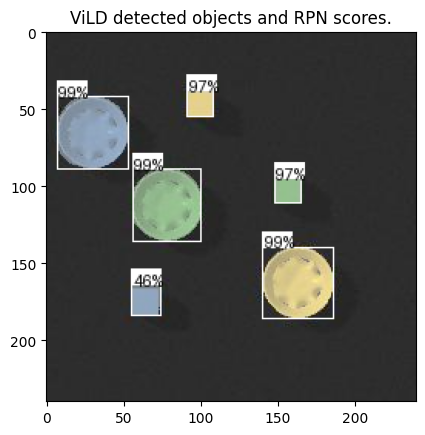

In [25]:
category_names = ['blue block',
                  'red block',
                  'green block',
                  'orange block',
                  'yellow block',
                  'purple block',
                  'pink block',
                  'cyan block',
                  'brown block',
                  'gray block',

                  'blue bowl',
                  'red bowl',
                  'green bowl',
                  'orange bowl',
                  'yellow bowl',
                  'purple bowl',
                  'pink bowl',
                  'cyan bowl',
                  'brown bowl',
                  'gray bowl']
image_path = '../outputs/tmp2.jpg'

#@markdown ViLD settings.
category_name_string = ";".join(category_names)
max_boxes_to_draw = 8 #@param {type:"integer"}

# Extra prompt engineering: swap A with B for every (A, B) in list.
prompt_swaps = [('block', 'cube')]

nms_threshold = 0.4 #@param {type:"slider", min:0, max:0.9, step:0.05}
min_rpn_score_thresh = 0.4  #@param {type:"slider", min:0, max:1, step:0.01}
min_box_area = 10 #@param {type:"slider", min:0, max:10000, step:1.0}
max_box_area = 3000  #@param {type:"slider", min:0, max:10000, step:1.0}
vild_params = max_boxes_to_draw, nms_threshold, min_rpn_score_thresh, min_box_area, max_box_area
found_objects = vild(image_path, category_name_string, vild_params, plot_on=True, prompt_swaps=prompt_swaps)

In [26]:
class ScriptedPolicy():

  def __init__(self, env):
    self.env = env

  def step(self, text, obs):
    print(f'Input: {text}')

    # Parse pick and place targets.
    pick_text, place_text = text.split('and')
    pick_target, place_target = None, None
    for name in PICK_TARGETS.keys():
      if name in pick_text:
        pick_target = name
        break
    for name in PLACE_TARGETS.keys():
      if name in place_text:
        place_target = name
        break

    # Admissable targets only.
    assert pick_target is not None
    assert place_target is not None

    pick_id = self.env.obj_name_to_id[pick_target]
    pick_pose = pybullet.getBasePositionAndOrientation(pick_id)
    pick_position = np.float32(pick_pose[0])

    if place_target in self.env.obj_name_to_id:
      place_id = self.env.obj_name_to_id[place_target]
      place_pose = pybullet.getBasePositionAndOrientation(place_id)
      place_position = np.float32(place_pose[0])
    else:
      place_position = np.float32(PLACE_TARGETS[place_target])

    # Add some noise to pick and place positions.
    # pick_position[:2] += np.random.normal(scale=0.01)
    place_position[:2] += np.random.normal(scale=0.01)

    act = {'pick': pick_position, 'place': place_position}
    return act

In [27]:
#@markdown Collect demonstrations with a scripted expert, or download a pre-generated dataset.
import os
import pickle
import matplotlib.pyplot as plt

load_pregenerated = True  #@param {type:"boolean"}

# Load pre-existing dataset.
if load_pregenerated:
  if not os.path.exists('../resources/dataset-9999.pkl'):
    # !gdown --id 1TECwTIfawxkRYbzlAey0z1mqXKcyfPc-
    !gdown --id 1yCz6C-6eLWb4SFYKdkM-wz5tlMjbG2h8
  dataset = pickle.load(open('../resources/dataset-9999.pkl', 'rb'))  # ~10K samples.
  dataset_size = len(dataset['text'])

# Generate new dataset.
else:
  dataset = {}
  dataset_size = 2  # Size of new dataset.
  dataset['image'] = np.zeros((dataset_size, 224, 224, 3), dtype=np.uint8)
  dataset['pick_yx'] = np.zeros((dataset_size, 2), dtype=np.int32)
  dataset['place_yx'] = np.zeros((dataset_size, 2), dtype=np.int32)
  dataset['text'] = []
  policy = ScriptedPolicy(env)
  data_idx = 0
  while data_idx < dataset_size:
    np.random.seed(data_idx)
    num_pick, num_place = 3, 3

    # Select random objects for data collection.
    pick_items = list(PICK_TARGETS.keys())
    pick_items = np.random.choice(pick_items, size=num_pick, replace=False)
    place_items = list(PLACE_TARGETS.keys())
    for pick_item in pick_items:  # For simplicity: place items != pick items.
      place_items.remove(pick_item)
    place_items = np.random.choice(place_items, size=num_place, replace=False)
    config = {'pick': pick_items, 'place': place_items}

    # Initialize environment with selected objects.
    obs = env.reset(config)

    # Create text prompts.
    prompts = []
    for i in range(len(pick_items)):
      pick_item = pick_items[i]
      place_item = place_items[i]
      prompts.append(f'Pick the {pick_item} and place it on the {place_item}.')

    # Execute 3 pick and place actions.
    for prompt in prompts:
      act = policy.step(prompt, obs)
      dataset['text'].append(prompt)
      dataset['image'][data_idx, ...] = obs['image'].copy()
      dataset['pick_yx'][data_idx, ...] = xyz_to_pix(act['pick'])
      dataset['place_yx'][data_idx, ...] = xyz_to_pix(act['place'])
      data_idx += 1
      obs, _, _, _ = env.step(act)
      debug_clip = ImageSequenceClip(env.cache_video, fps=25)
      display(debug_clip.ipython_display(autoplay=1, loop=1))
      env.cache_video = []
      if data_idx >= dataset_size:
        break

  pickle.dump(dataset, open(f'dataset-{dataset_size}.pkl', 'wb'))

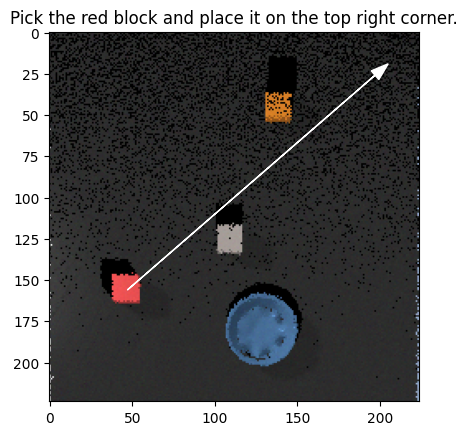

In [28]:
#@markdown Show a demonstration example from the dataset.
img = dataset['image'][0]
pick_yx = dataset['pick_yx'][0]
place_yx = dataset['place_yx'][0]
text = dataset['text'][0]
plt.title(text)
plt.imshow(img)
plt.arrow(pick_yx[1], pick_yx[0], place_yx[1]-pick_yx[1], place_yx[0]-pick_yx[0], color='w', head_starts_at_zero=False, head_width=7, length_includes_head=True)
plt.show()

In [29]:
import imports

## Model (variant of CLIP)

In [30]:
from flax import linen as nn

class ResNetBlock(nn.Module):
  """ResNet pre-Activation block. https://arxiv.org/pdf/1603.05027.pdf"""
  features: int
  stride: int = 1

  def setup(self):
    self.conv0 = nn.Conv(self.features // 4, (1, 1), (self.stride, self.stride))
    self.conv1 = nn.Conv(self.features // 4, (3, 3))
    self.conv2 = nn.Conv(self.features, (1, 1))
    self.conv3 = nn.Conv(self.features, (1, 1), (self.stride, self.stride))

  def __call__(self, x):
    y = self.conv0(nn.relu(x))
    y = self.conv1(nn.relu(y))
    y = self.conv2(nn.relu(y))
    if x.shape != y.shape:
      x = self.conv3(nn.relu(x))
    return x + y


class UpSample(nn.Module):
  """Simple 2D 2x bilinear upsample."""

  def __call__(self, x):
    B, H, W, C = x.shape
    new_shape = (B, H * 2, W * 2, C)
    return jax.image.resize(x, new_shape, 'bilinear')


class ResNet(nn.Module):
  """Hourglass 53-layer ResNet with 8-stride."""
  out_dim: int

  def setup(self):
    self.dense0 = nn.Dense(8)

    self.conv0 = nn.Conv(64, (3, 3), (1, 1))
    self.block0 = ResNetBlock(64)
    self.block1 = ResNetBlock(64)
    self.block2 = ResNetBlock(128, stride=2)
    self.block3 = ResNetBlock(128)
    self.block4 = ResNetBlock(256, stride=2)
    self.block5 = ResNetBlock(256)
    self.block6 = ResNetBlock(512, stride=2)
    self.block7 = ResNetBlock(512)

    self.block8 = ResNetBlock(256)
    self.block9 = ResNetBlock(256)
    self.upsample0 = UpSample()
    self.block10 = ResNetBlock(128)
    self.block11 = ResNetBlock(128)
    self.upsample1 = UpSample()
    self.block12 = ResNetBlock(64)
    self.block13 = ResNetBlock(64)
    self.upsample2 = UpSample()
    self.block14 = ResNetBlock(16)
    self.block15 = ResNetBlock(16)
    self.conv1 = nn.Conv(self.out_dim, (3, 3), (1, 1))

  def __call__(self, x, text):

    # # Project and concatenate CLIP features (early fusion).
    # text = self.dense0(text)
    # text = jnp.expand_dims(text, axis=(1, 2))
    # text = jnp.broadcast_to(text, x.shape[:3] + (8,))
    # x = jnp.concatenate((x, text), axis=-1)

    x = self.conv0(x)
    x = self.block0(x)
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.block6(x)
    x = self.block7(x)

    # Concatenate CLIP features (mid-fusion).
    text = jnp.expand_dims(text, axis=(1, 2))
    text = jnp.broadcast_to(text, x.shape)
    x = jnp.concatenate((x, text), axis=-1)

    x = self.block8(x)
    x = self.block9(x)
    x = self.upsample0(x)
    x = self.block10(x)
    x = self.block11(x)
    x = self.upsample1(x)
    x = self.block12(x)
    x = self.block13(x)
    x = self.upsample2(x)
    x = self.block14(x)
    x = self.block15(x)
    x = self.conv1(x)
    return x


class TransporterNets(nn.Module):
  """TransporterNet with 3 ResNets (translation only)."""

  def setup(self):
    # Picking affordances.
    self.pick_net = ResNet(1)

    # Pick-conditioned placing affordances.
    self.q_net = ResNet(3)  # Query (crop around pick location).
    self.k_net = ResNet(3)  # Key (place features).
    self.crop_size = 64
    self.crop_conv = nn.Conv(features=1, kernel_size=(self.crop_size, self.crop_size), use_bias=False, dtype=jnp.float32, padding='SAME')

  def __call__(self, x, text, p=None, train=True):
    B, H, W, C = x.shape
    pick_out = self.pick_net(x, text)  # (B, H, W, 1)

    # Get key features.
    k = self.k_net(x, text)

    # Add 0-padding before cropping.
    h = self.crop_size // 2
    x_crop = jnp.pad(x, [(0, 0), (h, h), (h, h), (0, 0)], 'maximum')

    # Get query features and convolve them over key features.
    place_out = jnp.zeros((0, H, W, 1), jnp.float32)
    for b in range(B):

      # Get coordinates at center of crop.
      if p is None:
        pick_out_b = pick_out[b, ...]  # (H, W, 1)
        pick_out_b = pick_out_b.flatten()  # (H * W,)
        amax_i = jnp.argmax(pick_out_b)
        v, u = jnp.unravel_index(amax_i, (H, W))
      else:
        v, u = p[b, :]

      # Get query crop.
      x_crop_b = jax.lax.dynamic_slice(x_crop, (b, v, u, 0), (1, self.crop_size, self.crop_size, x_crop.shape[3]))
      # x_crop_b = x_crop[b:b+1, v:(v + self.crop_size), u:(u + self.crop_size), ...]

      # Convolve q (query) across k (key).
      q = self.q_net(x_crop_b, text[b:b+1, :])  # (1, H, W, 3)
      q = jnp.transpose(q, (1, 2, 3, 0))  # (H, W, 3, 1)
      place_out_b = self.crop_conv.apply({'params': {'kernel': q}}, k[b:b+1, ...])  # (1, H, W, 1)
      scale = 1 / (self.crop_size * self.crop_size)  # For higher softmax temperatures.
      place_out_b *= scale
      place_out = jnp.concatenate((place_out, place_out_b), axis=0)

    return pick_out, place_out


def n_params(params):
  return jnp.sum(jnp.int32([n_params(v) if isinstance(v, dict) or isinstance(v, flax.core.frozen_dict.FrozenDict) else np.prod(v.shape) for v in params.values()]))
    

## Training

In [31]:
#@markdown Compute CLIP features for text in the dataset.
# Precompute CLIP features for all text in training dataset.
text_tokens = clip.tokenize(dataset['text']).cuda()
text_i = 0
data_text_feats = np.zeros((0, 512), dtype=np.float32)
while text_i < len(text_tokens):
  batch_size = min(len(text_tokens) - text_i, 512)
  text_batch = text_tokens[text_i:text_i+batch_size]
  with torch.no_grad():
    batch_feats = clip_model.encode_text(text_batch).float()
  batch_feats /= batch_feats.norm(dim=-1, keepdim=True)
  batch_feats = np.float32(batch_feats.cpu())
  data_text_feats = np.concatenate((data_text_feats, batch_feats), axis=0)
  text_i += batch_size

In [32]:
from optax import adam

In [33]:
#@markdown Define Transporter Nets train and eval functions
# Train with InfoNCE loss over pick and place positions.
@jax.jit
def train_step(optimizer, batch):
  def loss_fn(params):
    batch_size = batch['img'].shape[0]
    pick_logits, place_logits = TransporterNets().apply({'params': params}, batch['img'], batch['text'], batch['pick_yx'])

    # InfoNCE pick loss.
    pick_logits = pick_logits.reshape(batch_size, -1)
    pick_onehot = batch['pick_onehot'].reshape(batch_size, -1)
    pick_loss = jnp.mean(optax.softmax_cross_entropy(logits=pick_logits, labels=pick_onehot), axis=0)

    # InfoNCE place loss.
    place_logits = place_logits.reshape(batch_size, -1)
    place_onehot = batch['place_onehot'].reshape(batch_size, -1)
    place_loss = jnp.mean(optax.softmax_cross_entropy(logits=place_logits, labels=place_onehot), axis=0)
    
    loss = pick_loss + place_loss
    return loss, (pick_logits, place_logits)
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grad = grad_fn(optimizer.target)
  optimizer = optimizer.apply_gradient(grad)
  return optimizer, loss, grad, logits

@jax.jit
def eval_step(params, batch):
  pick_logits, place_logits = TransporterNets().apply({'params': params}, batch['img'], batch['text'])
  return pick_logits, place_logits

# Coordinate map (i.e. position encoding).
coord_x, coord_y = np.meshgrid(np.linspace(-1, 1, 224), np.linspace(-1, 1, 224), sparse=False, indexing='ij')
coords = np.concatenate((coord_x[..., None], coord_y[..., None]), axis=2)
     

In [ ]:
#@markdown **TensorBoard:** Displays an interactive TensorBoard.
name = datetime.datetime.now().strftime(f'%Y-%m-%d-%H:%M:%S-cliport')
logdir = os.path.join("logs", name)
writer = tensorboard.SummaryWriter(logdir)
%tensorboard --logdir logs

In [35]:
#@markdown Train your own model, or load a pretrained one.
load_pretrained = True  #@param {type:"boolean"}

# Initialize model weights using dummy tensors.
rng = jax.random.PRNGKey(0)
rng, key = jax.random.split(rng)
init_img = jnp.ones((4, 224, 224, 5), jnp.float32)
init_text = jnp.ones((4, 512), jnp.float32)
init_pix = jnp.zeros((4, 2), np.int32)
init_params = TransporterNets().init(key, init_img, init_text, init_pix)['params']
print(f'Model parameters: {n_params(init_params):,}')
optim = flax.optim.Adam(learning_rate=1e-4).create(init_params)
# optim = optax.adam(learning_rate=1e-4)

if load_pretrained:
  ckpt_path = f'../resources/ckpt_{40000}'
  if not os.path.exists(ckpt_path):
    !gdown --id 1Nq0q1KbqHOA5O7aRSu4u7-u27EMMXqgP
  optim = checkpoints.restore_checkpoint(ckpt_path, optim)
  print('Loaded:', ckpt_path)
else:

  # Training loop.
  batch_size = 8
  for train_iter in range(1, 40001):
    batch_i = np.random.randint(dataset_size, size=batch_size)
    text_feat = data_text_feats[batch_i, ...]
    img = dataset['image'][batch_i, ...] / 255
    img = np.concatenate((img, np.broadcast_to(coords[None, ...], (batch_size,) + coords.shape)), axis=3)

    # Get onehot label maps.
    pick_yx = np.zeros((batch_size, 2), dtype=np.int32)
    pick_onehot = np.zeros((batch_size, 224, 224), dtype=np.float32)
    place_onehot = np.zeros((batch_size, 224, 224), dtype=np.float32)
    for i in range(len(batch_i)):
      pick_y, pick_x  = dataset['pick_yx'][batch_i[i], :]
      place_y, place_x = dataset['place_yx'][batch_i[i], :]
      pick_onehot[i, pick_y, pick_x] = 1
      place_onehot[i, place_y, place_x] = 1
      # pick_onehot[i, ...] = scipy.ndimage.gaussian_filter(pick_onehot[i, ...], sigma=3)

      # Data augmentation (random translation).
      roll_y, roll_x = np.random.randint(-112, 112, size=2)
      img[i, ...] = np.roll(img[i, ...], roll_y, axis=0)
      img[i, ...] = np.roll(img[i, ...], roll_x, axis=1)
      pick_onehot[i, ...] = np.roll(pick_onehot[i, ...], roll_y, axis=0)
      pick_onehot[i, ...] = np.roll(pick_onehot[i, ...], roll_x, axis=1)
      place_onehot[i, ...] = np.roll(place_onehot[i, ...], roll_y, axis=0)
      place_onehot[i, ...] = np.roll(place_onehot[i, ...], roll_x, axis=1)
      pick_yx[i, 0] = pick_y + roll_y
      pick_yx[i, 1] = pick_x + roll_x

    # Backpropagate.
    batch = {}
    batch['img'] = jnp.float32(img)
    batch['text'] = jnp.float32(text_feat)
    batch['pick_yx'] = jnp.int32(pick_yx)
    batch['pick_onehot'] = jnp.float32(pick_onehot)
    batch['place_onehot'] = jnp.float32(place_onehot)
    rng, batch['rng'] = jax.random.split(rng)
    optim, loss, _, _ = train_step(optim, batch)
    writer.scalar('train/loss', loss, train_iter)

    if train_iter % np.power(10, min(4, np.floor(np.log10(train_iter)))) == 0:
      print(f'Train Step: {train_iter} Loss: {loss}')
    
    if train_iter % 1000 == 0:
      checkpoints.save_checkpoint('.', optim, train_iter, prefix='ckpt_', keep=100000, overwrite=True)

Model parameters: 4,259,095


AttributeError: module 'flax' has no attribute 'optim'

'0.8.5'

## Setup SayCan

In [34]:
#@title LLM Cache
overwrite_cache = True
if overwrite_cache:
  LLM_CACHE = {}

In [84]:
from openai.types import Completion
def old_gpt3_call(engine="text-ada-001", prompt="", max_tokens=128, temperature=0, 
              logprobs=1, echo=False):
  full_query = ""
  for p in prompt:
    full_query += p
  id = tuple((engine, full_query, max_tokens, temperature, logprobs, echo))
  if id in LLM_CACHE.keys():
    print('cache hit, returning')
    response = LLM_CACHE[id]
  else: 
    # response = openai.Completion.create(engine=engine, 
    #                                     prompt=prompt, 
    #                                     max_tokens=max_tokens, 
    #                                     temperature=temperature,
    #                                     logprobs=logprobs,
    #                                     echo=echo)
    response = openai.Completion.create(model = engine,
                                        prompt=prompt,
                                        max_tokens=max_tokens,
                                        temperature=temperature,
                                        logprobs=logprobs,
                                        echo=echo)
    LLM_CACHE[id] = response
  return response

def gpt3_call(model, prompt="", max_tokens=128, temperature=0, 
              logprobs=None, echo=False):
    full_query = ""
    # for p in prompt:
    #     full_query += p
    # OpenAI's Chat API expects a list of messages in a conversation.
    # messages = [{"role": "user", "content": prompt}]
    # messages = [{"role": "user", "content": [{"type": "text", "data": txt} for txt in prompt]}]
    messages=[
    {"role": "system", "content": "You are an expert in finding the most relevant and accurate options to queries."},
    {"role": "user", "content": prompt}
    ]
    cache_key = (model, full_query, max_tokens, temperature, logprobs, echo)
    print("MESSAGES:", messages)
    if cache_key in LLM_CACHE:
        print('cache hit, returning')
        response = LLM_CACHE[cache_key]
    else:
        new_client = OpenAI(api_key=openai_api_key)
        print("MODEL USED: ", model)
        response = new_client.chat.completions.create(model=model,
            messages=messages,
            max_tokens=max_tokens,
            temperature=temperature,
            n=1,  # Only generate one completion
            logprobs=logprobs,
            # echo=echo
            )
        LLM_CACHE[cache_key] = response
    
    return response
def gpt3_scoring(query, options, engine, limit_num_options=None, option_start="\n", verbose=False,print_tokens=False):
    if limit_num_options:
        options = options[:limit_num_options]
    verbose and print("Scoring", len(options), "options")
    gpt3_prompt_options = [query + option for option in options]
    option_prompt = {chr(10).join(f'{i+1}. {statement}' for i, statement in enumerate(options))}
    gpt_prompt = f"Query: {query} \n\n Here are list of options: \n\n {option_prompt} \n\n Find the best suited option for the query"
    # print("gpt3_prompt_options type ", type(gpt3_prompt_options))
    # print("GPT4 PROMPT: ", gpt3_prompt_options)
    response = gpt3_call(
        model=engine,
        prompt=gpt_prompt,
        # max_tokens=0,
        logprobs=False,
        temperature=0,
        echo=True, )

    scores = {}
    # for option, choice in zip(options, response["choices"]):
    #     tokens = choice["logprobs"]["tokens"]
    #     token_logprobs = choice["logprobs"]["token_logprobs"]
    # 
    #     total_logprob = 0
    #     for token, token_logprob in zip(reversed(tokens), reversed(token_logprobs)):
    #         print_tokens and print(token, token_logprob)
    #         if option_start is None and not token in option:
    #             break
    #         if token == option_start:
    #             break
    #         total_logprob += token_logprob
    #     scores[option] = total_logprob
    # 
    # for i, option in enumerate(sorted(scores.items(), key=lambda x: -x[1])):
    #     verbose and print(option[1], "\t", option[0])
    #     if i >= 10:
    #         break

    return scores, response

def make_options(pick_targets=None, place_targets=None, options_in_api_form=True, termination_string="done()"):
  if not pick_targets:
    pick_targets = PICK_TARGETS
  if not place_targets:
    place_targets = PLACE_TARGETS
  options = []
  for pick in pick_targets:
    for place in place_targets:
      if options_in_api_form:
        option = "robot.pick_and_place({}, {})".format(pick, place)
      else:
        option = "Pick the {} and place it on the {}.".format(pick, place)
      options.append(option)

  options.append(termination_string)
  print("Considering", len(options), "options")
  return options

In [85]:
query = "To pick the blue block and put it on the red block, I should: "
options = make_options(PICK_TARGETS, PLACE_TARGETS)
scores, response = gpt3_scoring(query, options, engine=ENGINE, limit_num_options=5, option_start='\n', verbose=True)

Considering 53 options
Scoring 5 options
MESSAGES: [{'role': 'system', 'content': 'You are an expert in finding the most relevant and accurate options to queries.'}, {'role': 'user', 'content': "Query: To pick the blue block and put it on the red block, I should:  \n\n Here are list of options: \n\n {'1. robot.pick_and_place(blue block, blue block)\\n2. robot.pick_and_place(blue block, red block)\\n3. robot.pick_and_place(blue block, green block)\\n4. robot.pick_and_place(blue block, yellow block)\\n5. robot.pick_and_place(blue block, blue bowl)'} \n\n Find the best suited option for the query"}]
MODEL USED:  gpt-4o-mini


In [92]:
response

ChatCompletion(id='chatcmpl-A1DRaDV3HtufQfyEVFiXsWq8e4aHs', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The best suited option for the query "To pick the blue block and put it on the red block" is:\n\n**2. robot.pick_and_place(blue block, red block)**\n\nThis option correctly describes the action of picking the blue block and placing it on the red block.', refusal=None, role='assistant', function_call=None, tool_calls=None))], created=1724853370, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier=None, system_fingerprint='fp_5bd87c427a', usage=CompletionUsage(completion_tokens=57, prompt_tokens=132, total_tokens=189))

In [69]:
from openai import OpenAI
client = OpenAI(api_key=openai_api_key)

response = client.chat.completions.create(
    model= "gpt-4o-mini",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "To pick the blue block and put it on the red block, I should:\nrobot.pick_and_place(blue block, blue block)'}"},
        # {"role": "assistant", "content": "The Los Angeles Dodgers won the World Series in 2020."},
        {"role": "user", "content": "To pick the blue block and put it on the red block, I should:\nrobot.pick_and_place(blue block, red block)'}"},
        # {"role": "user", "content": "Chose the correct parameterised robot function"}
    ],
    logprobs=True
)

In [73]:
tasks = ['To pick the blue block and put it on the red block, I should:\nrobot.pick_and_place(blue block, blue block)', 'To pick the blue block and put it on the red block, I should:\nrobot.pick_and_place(blue block, red block)', 'To pick the blue block and put it on the red block, I should:\nrobot.pick_and_place(blue block, green block)', 'To pick the blue block and put it on the red block, I should:\nrobot.pick_and_place(blue block, yellow block)', 'To pick the blue block and put it on the red block, I should:\nrobot.pick_and_place(blue block, blue bowl)']
messages = [{"role" : "user", "content": cont} for cont in tasks]
messages

[{'role': 'user',
  'content': 'To pick the blue block and put it on the red block, I should:\nrobot.pick_and_place(blue block, blue block)'},
 {'role': 'user',
  'content': 'To pick the blue block and put it on the red block, I should:\nrobot.pick_and_place(blue block, red block)'},
 {'role': 'user',
  'content': 'To pick the blue block and put it on the red block, I should:\nrobot.pick_and_place(blue block, green block)'},
 {'role': 'user',
  'content': 'To pick the blue block and put it on the red block, I should:\nrobot.pick_and_place(blue block, yellow block)'},
 {'role': 'user',
  'content': 'To pick the blue block and put it on the red block, I should:\nrobot.pick_and_place(blue block, blue bowl)'}]

In [39]:
import openai
from openai import OpenAI
client = OpenAI(api_key=openai_api_key)
openai.api_key = openai_api_key

def read_context(file_path):
    with open(file_path, 'r') as file:
        context = file.read()
    return context

def create_prompt(context, query, options):
    prompt = f"Context:\n{context}\n\nQuery:\n{query}\n\nOptions:\n"
    for i, option in enumerate(options, 1):
        prompt += f"{i}. {option}\n"
    prompt += "\nPlease select the most suitable option (1, 2, 3, or 4):"
    return prompt

def get_gpt_response(prompt):
    response = openai.Completion.create(
        engine="text-davinci-003",  # You can use other models like 'gpt-3.5-turbo'
        prompt=prompt,
        max_tokens=50,
        temperature=0
    )
    return response.choices[0].text.strip()


In [46]:
context_file = "../resources/llm_pycram_designators.txt"
context = read_context(context_file)

instruction = "pick up the apple and put it on the kitchen_island_surface"

query = f"resolve the natural langugae instruction {instruction} into a python code of action designators from the context"

messages = [
    {"role": "system", "content": "You are a helpful assistant that translates natural language instructions into Python code for robotic action plan for pr2 robot."},
    {"role": "assistant", "content": context},
    {"role": "user", "content": query},
    {"role": "user", "content": "plan navigation for robot if needed and Output only python code"}
]

In [47]:
response = client.chat.completions.create(
    model = "gpt-4o-mini",
    messages = messages,
    max_tokens=1000,
    temperature=0,
)

In [48]:
code = response.choices[0].message.content.strip()

with open("../outputs/gen_code.py", "w") as file:
    file.write(code)

In [38]:
print(code)

```python
# Define the object designator for the apple
apple_designator = ObjectDesignatorDescription()  # Assuming this is defined elsewhere

# Define the action designator to pick up the apple
pick_up_action = PickUpAction(
    object_designator_description=apple_designator,
    arms=["left_arm", "right_arm"],
    grasps=["left", "right"]
)

# Define the target location for the bench
bench_location = Pose()  # Assuming this is defined with the appropriate coordinates

# Define the action designator to place the apple on the bench
place_action = PlaceAction(
    object_designator_description=apple_designator,
    target_locations=[bench_location],
    arms=["left_arm", "right_arm"]
)

# Ground the actions to create performable actions
performable_pick_up = pick_up_action.ground()
performable_place = place_action.ground()

# Execute the actions
performable_pick_up.perform()
performable_place.perform()
```
